In [12]:
# 运行环境
# Python3.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/

In [13]:
# MNIST数据集准备
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
import math
# batch_size超参，根据硬件配置相应大小
batch_size = 32

trans_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# MNIST数据集每张图片是灰度图片，大小为28x28
trainset = MNIST('data', train=True, download=True, transform=trans_img)
testset = MNIST('data', train=False, download=True, transform=trans_img)
train_loader = DataLoader(trainset, batch_size=batch_size, 
                          shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=batch_size, 
                          shuffle=True, num_workers=1)# 运行环境
# Python2.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/# 运行环境
# Python2.7
# PyTorch 0.2，安装参考https://pytorch.org/get-started/locally/

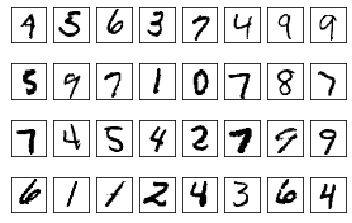

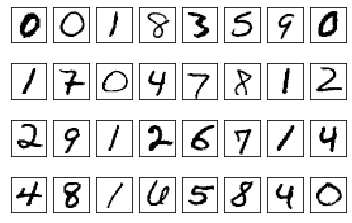

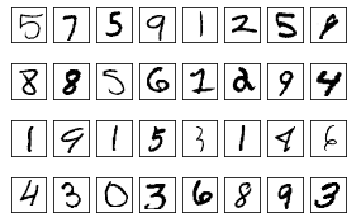

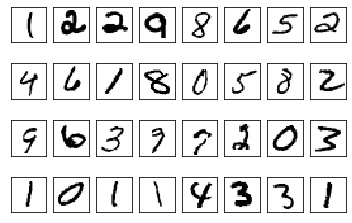

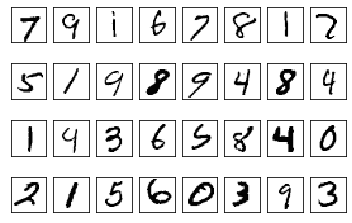

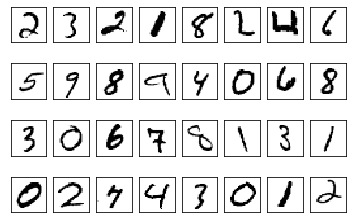

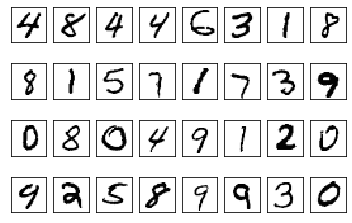

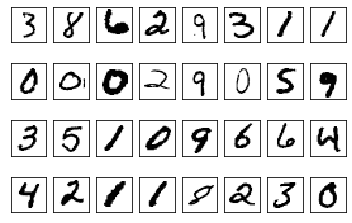

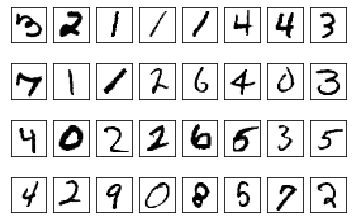

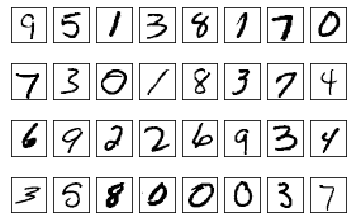

In [14]:
import matplotlib.pyplot as plt

plt.ion()
cnt = 0
for (img_batch, label) in train_loader:
    cnt += 1
    if cnt > 10:
        break
    fig, ax = plt.subplots(
        nrows=4,
        ncols=8,
        sharex=True,
        sharey=True, )
    ax = ax.flatten()
    for i in range(32):
        img = img_batch[i].numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.show()
    plt.close()
plt.ioff()

In [4]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        # 模型参数初始化，其中全连接层的参数使用了xavier初始化方法。
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [8]:
from torch import optim
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
model = Net().cuda()
learning_rate = 0.001
criterion  = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# 总的训练轮数
epochs = 50
train_losses=[]
test_losses=[]
for epoch in range(epochs):
    running_loss, running_acc = 0., 0.
    for (img, label) in train_loader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predict = torch.max(output, 1)
        correct_num = (predict == label).sum()
        running_acc += correct_num.item()
        
    running_loss /= len(trainset)
    running_acc /= len(trainset)
    
    with torch.no_grad():
        test_loss, test_acc = 0., 0.
        for images, labels in test_loader:
            images = Variable(images).cuda()
            labels = Variable(labels).cuda()
            output = model(images)
            loss = criterion(output, labels)

            test_loss += loss.item()
            _, predict = torch.max(output, 1)
            correct_num = (predict == labels).sum()
            test_acc += correct_num.item()
    
    test_loss /=len(testset)
    test_acc /=len(testset)
    
    train_losses.append(running_loss)
    test_losses.append(test_loss)
    print("Epoch: {}/{}.. ".format(epoch+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accuracy: {:.3f} %".format(100*running_acc),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f} %".format(100*test_acc))
# 保存模型
torch.save(model, 'conv.pth.tar')

Epoch: 1/50..  Training Loss: 0.295..  Training Accuracy: 90.723 % Test Loss: 0.134..  Test Accuracy: 95.880 %
Epoch: 2/50..  Training Loss: 0.119..  Training Accuracy: 96.325 % Test Loss: 0.102..  Test Accuracy: 96.820 %
Epoch: 3/50..  Training Loss: 0.092..  Training Accuracy: 97.122 % Test Loss: 0.078..  Test Accuracy: 97.640 %
Epoch: 4/50..  Training Loss: 0.079..  Training Accuracy: 97.502 % Test Loss: 0.070..  Test Accuracy: 97.920 %
Epoch: 5/50..  Training Loss: 0.072..  Training Accuracy: 97.767 % Test Loss: 0.066..  Test Accuracy: 97.980 %
Epoch: 6/50..  Training Loss: 0.062..  Training Accuracy: 98.093 % Test Loss: 0.059..  Test Accuracy: 98.100 %
Epoch: 7/50..  Training Loss: 0.056..  Training Accuracy: 98.275 % Test Loss: 0.064..  Test Accuracy: 98.000 %
Epoch: 8/50..  Training Loss: 0.054..  Training Accuracy: 98.327 % Test Loss: 0.056..  Test Accuracy: 98.170 %
Epoch: 9/50..  Training Loss: 0.052..  Training Accuracy: 98.400 % Test Loss: 0.051..  Test Accuracy: 98.330 %
E

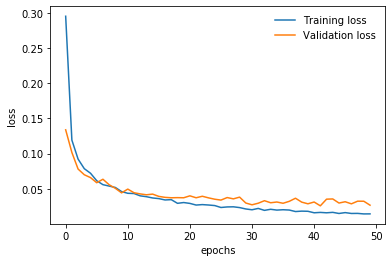

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(frameon=False)

In [11]:
model = torch.load('conv.pth.tar')
print('testing cnn model')
testloss, testacc = 0., 0.
for (img, label) in test_loader:
    img = Variable(img).cuda()
    label = Variable(label).cuda()    
    out = model(img)
    loss = criterion(out, label)
    testloss += loss.item()
    _, predict = torch.max(out, 1)
    correct_num = (predict == label).sum()
    testacc += correct_num.item() 
        
testloss /= len(testset)
testacc /= len(testset)
print('cnn model, Test: Loss: %.5f, Acc: %.2f' %
      (testloss, 100 * testacc))

testing cnn model
cnn model, Test: Loss: 0.03349, Acc: 99.04
